# QuPath cell detection in Python

This notebook attempts to replicate QuPath's cell detection in Python.

It is quite rough, and by no means an exact copy of the original method - but hopefully gives some useful insights into how it works.

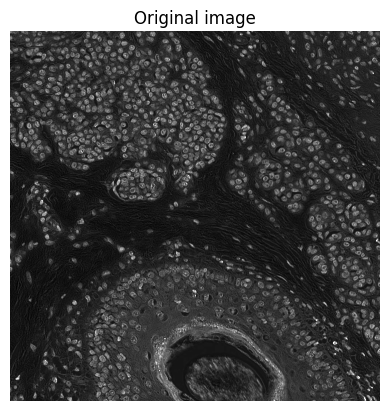

In [1]:
from imageio.v3 import imread

im = imread('CMU-1-detail.tif')

import numpy as np
from matplotlib import pyplot as plt

def show_image(im, title:str=None, clip_pct=0.05, cmap='gray'):
    args = {}
    if clip_pct and im.dtype != bool:
        args['vmin'] = np.percentile(im.ravel(), clip_pct)
        args['vmax'] = np.percentile(im.ravel(), 100-clip_pct)
    args['cmap'] = cmap
    plt.imshow(im, **args)
    plt.axis(False)
    if title:
        plt.title(title)
    plt.show()

show_image(im, title='Original image')

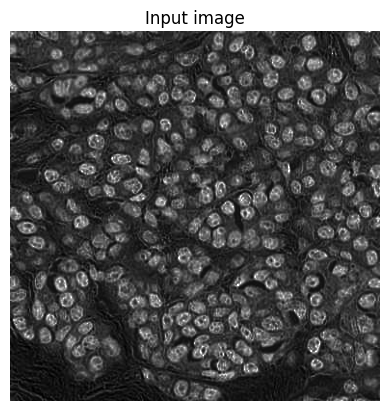

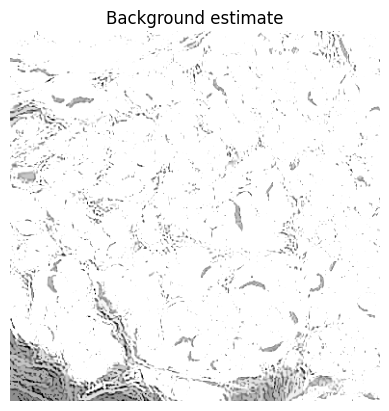

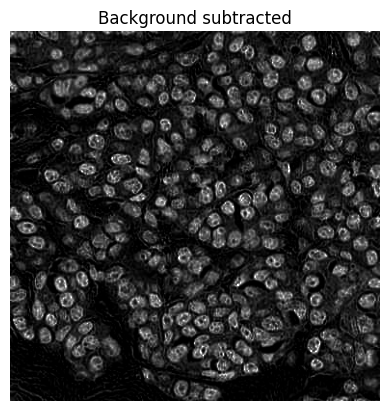

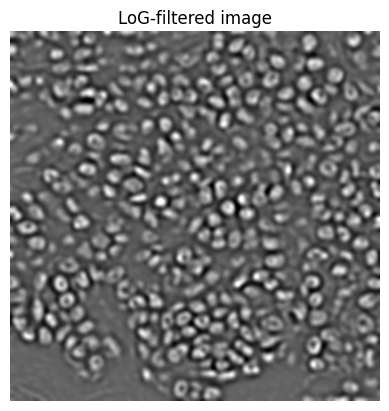

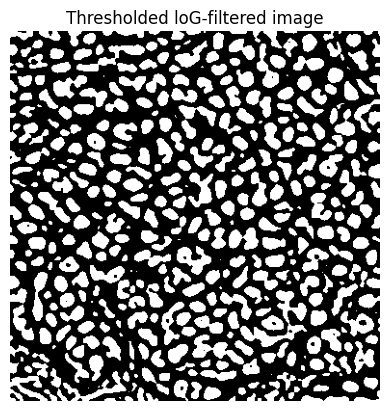

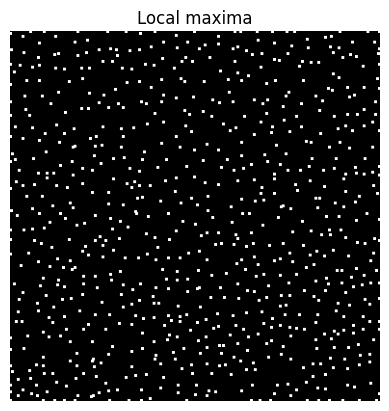

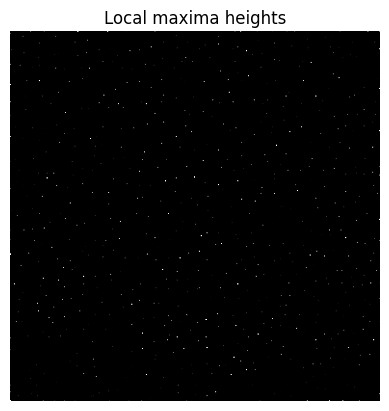

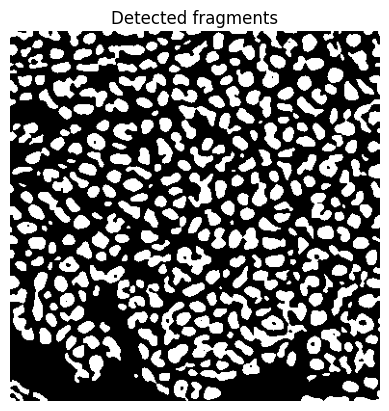

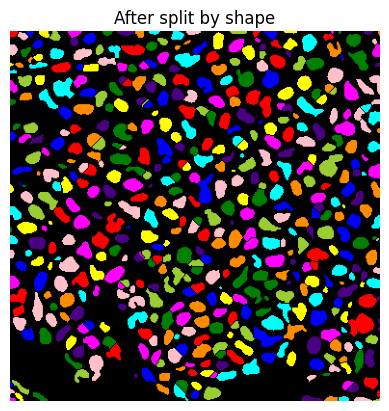

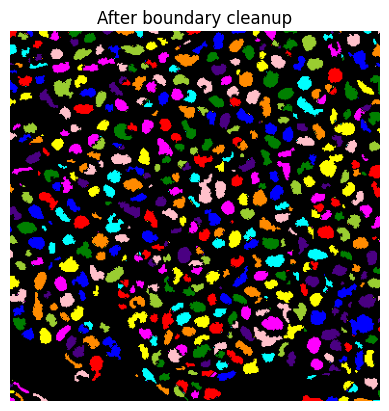

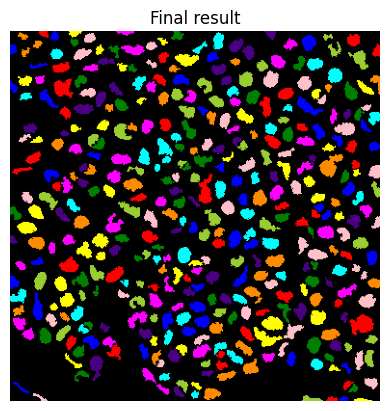

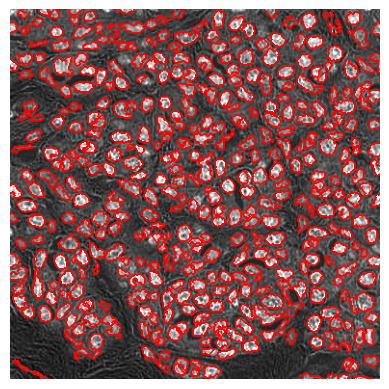

In [2]:
def _scale_length(size: float, pixel_size: float, do_round=True) -> float:
    """
    Convert length in calibrated units to a length in pixels
    """
    size_pixels = size / pixel_size
    return np.round(size_pixels) if do_round else size_pixels

def _scale_area(size: float, pixel_size: float, do_round=True) -> float:
    """
    Convert area in calibrated units to an area in pixels
    """
    size_pixels = size / (pixel_size * pixel_size)
    return np.round(size_pixels) if do_round else size_pixels

from scipy import ndimage
from skimage import morphology, segmentation
from skimage.color import label2rgb

from skimage.measure import regionprops


def cell_detection(im: np.ndarray,
                    pixel_size = 0.5, # Use to calibrate size-related parameters (usually in µm)
                    background_radius = 8,
                    median_radius = 0,
                    sigma = 1.5,
                    min_area = 10,
                    max_area = 400,
                    threshold = 0.1,
                    max_background_intensity = 2,
                    split_by_shape = True,
                    refine_boundaries = True, # True in QuPath by default (not adjustable)

#                     cell_expansion = 5.0,
#                     include_nucleus = True,
#                     smooth_boundaries = True,
#                     make_measurements = True,
                    do_debug = True
                  ) -> np.ndarray:
    
    # Ensure we're working with a 32-bit copy
    im = im.astype(np.float32, copy=True)
    
    if do_debug:
        show_image(im, title='Input image')
    
    # Estimate background using (modified) opening-by-reconstruction & subtract if needed (optional)
    bw_background_mask = None
    if background_radius > 0:
        
        # TODO: Use max_background_intensity here
        # See https://github.com/qupath/qupath/blob/v0.3.2/qupath-core-processing/src/main/java/qupath/imagej/detect/cells/WatershedCellDetection.java#L598
        
        strel = morphology.disk(_scale_length(background_radius, pixel_size))
        im_bg = morphology.erosion(im, strel)
        
        # Exclude regions with very high background values
        if max_background_intensity > 0:
            bw_background_mask = im_bg > max_background_intensity
            strel_bg = morphology.disk(_scale_length(background_radius*2, pixel_size))
            bw_background_mask = morphology.dilation(bw_background_mask, strel_bg)
            im_bg[bw_background_mask] = -np.inf
        
        im_bg = morphology.reconstruction(im_bg, im)
        
        im = im - im_bg
        if do_debug:
            show_image(im_bg, title='Background estimate')
            show_image(im, title='Background subtracted')
    
    # Apply median filter to reduce text (optional)
    if median_radius:
        strel = morphology.disk(_scale_length(median_radius, pixel_size))
        im = ndimage.median_filter(im, footprint=strel)
        if do_debug:
            show_image(im_log, title='Median-filtered image')
    
    # Approximate (inverted) Laplacian of Gaussian filter
    sigma_pixels = _scale_length(sigma, pixel_size, do_round=False)
    im_log = ndimage.gaussian_filter(im, sigma_pixels)
    im_log = ndimage.convolve(im_log, np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]))
    if do_debug:
        show_image(im_log, title='LoG-filtered image')
    
    # Threshold at zero (potential edges are at zero-crossings)
    bw_log = im_log > 0
    if do_debug:
        show_image(bw_log, title='Thresholded loG-filtered image')
    
    # Find local maxima (there is a small threshold value used as tolerance)
    bw_maxima = (im_log > 0.001) & (im_log == ndimage.maximum_filter(im_log, size=3))
    if do_debug:
        show_image(ndimage.maximum_filter(bw_maxima, size=3), title='Local maxima')
    
    # Find the height of the maxima
    im_log2 = im_log.copy()
    im_log2[bw_maxima] = -np.inf
    im_max_height = im_log - morphology.reconstruction(im_log2, im_log)
    if do_debug:
        show_image(im_max_height, title='Local maxima heights')

    # Apply watershed transform using the maxima, masked to positive values in im_log
    # This should give potential nucleus fragments as labeled regions
    lab, n_labels = ndimage.label(im_max_height > 0) # 4-connectivity
    lab = segmentation.watershed(-im_log, markers=lab, mask=im_log>0)
    
#     # Checking that label filling worked
#     lab = lab - ndimage.minimum_filter(lab, size=5)
#     show_image(label2rgb(lab))
#     _fill_labels(lab)
#     show_image(label2rgb(lab))

#     # Fill holes in labels (surrounded by the same label)
#     _fill_labels(lab)
    
    # Fill holes in labels & retain fragments with a high enough mean intensity, 
    # which don't occur in a region with a very high background
    bw_fragments = np.zeros(lab.shape, dtype=bool)
    regions = regionprops(lab)
    for props in regions:
        # Check mean of filled region
        if im[props.slice][props.image_filled].mean() > threshold:
            # Skip if in a region with high background
            if bw_background_mask is not None and bw_background_mask[props.slice][props.image_filled].any():
                continue
            # Retain filled-in fragments with sufficient mean intensity
            bw_fragments[props.slice][props.image_filled] = True
    
    # Refine detected fragments, reapplying the LoG-filtered image mask
    bw_fragments = ndimage.maximum_filter(bw_fragments, size=3)
    bw_fragments[im_log < 0] = False
    if do_debug:
        show_image(bw_fragments, title='Detected fragments')
    
    # Split using watershed applied to distance transform (optional)
    if split_by_shape:
        bw_fragments = ndimage.binary_fill_holes(bw_fragments)
        bw_dist = ndimage.distance_transform_edt(bw_fragments)
        
        # Try to match QuPath/ImageJ implementation of EDM().toWatershed(bp)
        # (it is likely to be a bit different)
        bw_dist_maxima = morphology.h_maxima(bw_dist, 0.6)
        lab = ndimage.label(bw_dist_maxima, structure=np.ones(shape=(3, 3)))[0]
        lab = segmentation.watershed(-bw_dist, lab, mask=bw_fragments, watershed_line=True)
        
        if do_debug:
            show_image(label2rgb(lab), title='After split by shape')

            
    # Minor boundary refinement, to try to counter the effects of the Gaussian filter expanding things
    # This seems to help in QuPath... but might not here
    if refine_boundaries and sigma_pixels > 1.5:
        bw = lab > 0
        im_boundary_cleanup = ndimage.gaussian_filter(im, 1.0)
        im_boundary_cleanup = ndimage.convolve(im_boundary_cleanup, np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]))
        bw_boundary_cleanup = im_boundary_cleanup > 0
        bw_boundary_cleanup[~bw] = False
        bw = ndimage.minimum_filter(bw, size=3)
        bw[bw_boundary_cleanup] = True
        lab = ndimage.label(bw)[0]
        if do_debug:
            show_image(label2rgb(lab), title='After boundary cleanup')

    # Regenerate regions, filling them in & removing ones that are too small, large or dim
    regions = regionprops(lab)
    min_area_pixels = _scale_area(min_area, pixel_size, do_round=False)
    max_area_pixels = _scale_area(max_area, pixel_size, do_round=False)
    bw = np.zeros(lab.shape, dtype=bool)
    for props in regions:
        area = props.area_filled
        # Check area
        if props.area_filled >= min_area_pixels and props.area_filled <= max_area_pixels:
            # Check intensity again (since hole-filling might have changed the situation)
            if im[props.slice][props.image_filled].mean() > threshold:
                bw[props.slice][props.image_filled] = True
    
    lab = ndimage.label(bw)[0]
    
    if do_debug:
        show_image(label2rgb(lab), title='Final result')
    
    return lab
    
im2 = im[:384, :384]
lab = cell_detection(im2, do_debug=True)

show_image(segmentation.mark_boundaries(
    np.clip((im2-im2.min())/(np.percentile(im2, 99) - im2.min()), 0, 1),
    lab, color=(1, 0, 0), mode='thick'))